<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/max_pred/candy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
#!pip install gplearn

In [85]:
#!pip install causalml

In [86]:
import pandas as pd
import numpy as np

import causalml

In [87]:
#!pip show causalml

In [88]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [89]:
rare_cols  = ["peanutyalmondy" , "nougat" , "bar" , "hard" , "caramel" , 'crispedricewafer']
data ["rare"] = 0
for r in rare_cols : data ["rare"] = data ["rare"] + data [r]
data ["rare"] = np.where (data ["rare"] >= 1 , 1 , 0)

In [90]:
data ["peanutyalmondy"].value_counts()

0    71
1    14
Name: peanutyalmondy, dtype: int64

array([[<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'fruity'}>,
        <Axes: title={'center': 'caramel'}>,
        <Axes: title={'center': 'peanutyalmondy'}>],
       [<Axes: title={'center': 'nougat'}>,
        <Axes: title={'center': 'crispedricewafer'}>,
        <Axes: title={'center': 'hard'}>,
        <Axes: title={'center': 'bar'}>],
       [<Axes: title={'center': 'pluribus'}>,
        <Axes: title={'center': 'sugarpercent'}>,
        <Axes: title={'center': 'pricepercent'}>,
        <Axes: title={'center': 'winpercent'}>],
       [<Axes: title={'center': 'rare'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

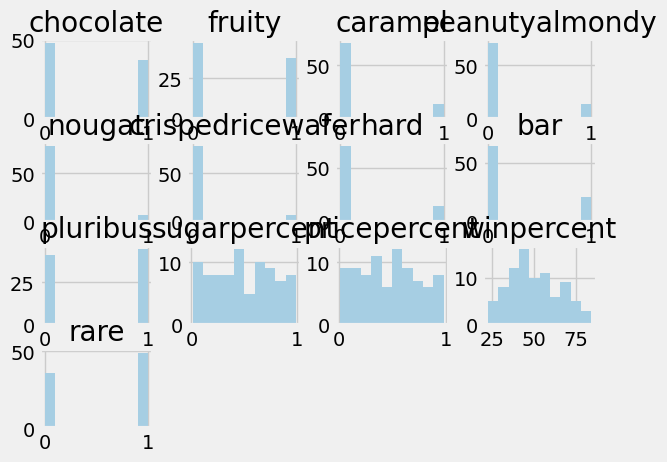

In [91]:
data.hist()

array([[<Axes: title={'center': 'winpercent'}>,
        <Axes: title={'center': 'sugarpercent'}>],
       [<Axes: title={'center': 'pricepercent'}>, <Axes: >]], dtype=object)

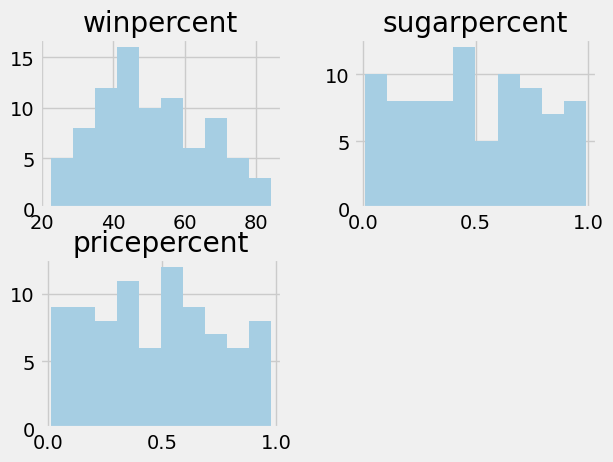

In [92]:
data[["winpercent" , "sugarpercent" , "pricepercent"]].hist()

In [93]:
data ["sugarpercent"] = data ["sugarpercent"] * 100
data ["pricepercent"] = data ["pricepercent"] * 100

In [94]:
y_col            = "winpercent"
non_feature_cols = ["competitorname",
                    "pricepercent" ,
                    "sugarpercent" ,
                    "fruity",
                    y_col
                    ]
for r in rare_cols :      non_feature_cols.append (r)
X                = data.drop (non_feature_cols,axis =1)
X

,chocolate,pluribus,rare
0,1,0,1
1,1,0,1
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
80,0,0,0
81,0,0,1
82,0,1,0
83,0,0,1


In [95]:
X.corr ()

,chocolate,pluribus,rare
chocolate,1.000000,-0.339675,0.416387
pluribus,-0.339675,1.000000,-0.446216
rare,0.416387,-0.446216,1.000000


array([[<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'pluribus'}>],
       [<Axes: title={'center': 'rare'}>, <Axes: >]], dtype=object)

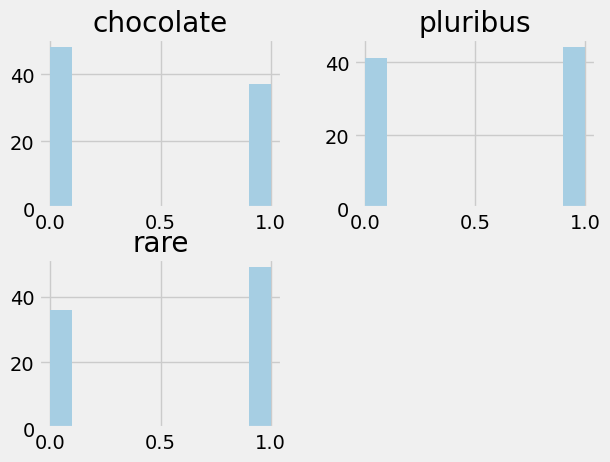

In [96]:
X.hist ()

In [97]:
y = data [y_col]
y

0     66.971725
1     67.602936
2     32.261086
3     46.116505
4     52.341465
        ...    
80    45.466282
81    39.011898
82    44.375519
83    41.904308
84    49.524113
Name: winpercent, Length: 85, dtype: float64

<Axes: >

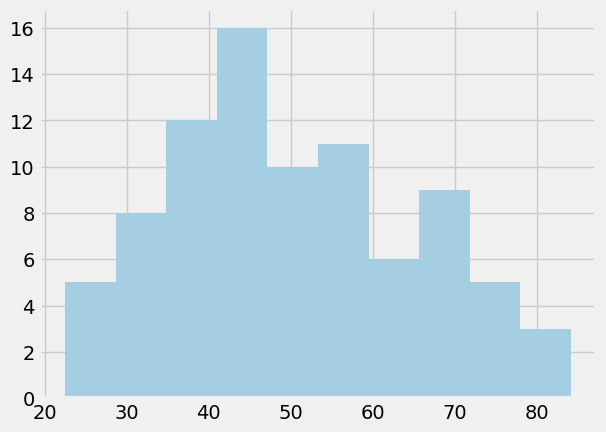

In [98]:
y.hist()

In [99]:
X.join (y).to_csv ("ATE_pp.csv")

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Define the parameter distribution
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 10), #20
    "min_samples_split": randint(2, 100), #11
    "min_samples_leaf": randint(1, 100) #11
}


# Setup the Randomized Search with cross-validation for the entire dataset
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=500, cv=3, random_state=42, n_jobs = -1 , verbose = 40)

# Perform the search on the entire dataset
random_search.fit(X, y)
best_params = random_search.best_params_


y_pred = random_search.predict (X)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")


Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Prediction R^2: 0.40965857596885924, RMSE: 11.238881971227157


In [105]:
best_params

{'max_depth': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 34,
 'n_estimators': 164}

In [106]:
candy_pred = X.join (y).join (pd.DataFrame (y_pred,columns = ["y_pred"]))
candy_pred

,chocolate,pluribus,rare,winpercent,y_pred
0,1,0,1,66.971725,60.910752
1,1,0,1,67.602936,60.910752
2,0,0,0,32.261086,42.402337
3,0,0,0,46.116505,42.402337
4,0,0,0,52.341465,42.402337
...,...,...,...,...,...
80,0,0,0,45.466282,42.402337
81,0,0,1,39.011898,41.823407
82,0,1,0,44.375519,42.446025
83,0,0,1,41.904308,41.823407


In [ ]:
candy_pred.plot.scatter ()

In [75]:
cv_df = pd.DataFrame (random_search.cv_results_)
#cv_df.to_csv ("hyperparams.csv")
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.482337,0.064208,0.017292,0.005511,9,52,9,160,"{'max_depth': 9, 'min_samples_leaf': 52, 'min_...",-0.553249,-0.069018,-0.027900,-0.256298,-0.168067,-0.214906,0.186889,391
1,0.384568,0.050892,0.013427,0.001035,7,83,8,174,"{'max_depth': 7, 'min_samples_leaf': 83, 'min_...",-0.551379,-0.068107,-0.035263,-0.261842,-0.150028,-0.213324,0.186245,349
2,0.421268,0.012551,0.014327,0.000502,5,88,6,199,"{'max_depth': 5, 'min_samples_leaf': 88, 'min_...",-0.544706,-0.057661,-0.027035,-0.263748,-0.158743,-0.210379,0.186669,263
3,0.211025,0.008395,0.009063,0.000752,5,22,6,101,"{'max_depth': 5, 'min_samples_leaf': 22, 'min_...",-0.285144,-0.012736,0.063581,-0.206121,-0.075630,-0.103210,0.126851,116
4,0.321727,0.050500,0.016071,0.006475,6,30,7,101,"{'max_depth': 6, 'min_samples_leaf': 30, 'min_...",-0.562084,-0.061686,-0.028969,-0.255973,-0.171968,-0.216136,0.190842,418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.562659,0.074394,0.022047,0.007646,8,39,4,157,"{'max_depth': 8, 'min_samples_leaf': 39, 'min_...",-0.545051,-0.054051,-0.029480,-0.260380,-0.170793,-0.211951,0.186131,305
496,0.420685,0.052760,0.014864,0.006143,8,12,4,117,"{'max_depth': 8, 'min_samples_leaf': 12, 'min_...",0.232842,0.566137,0.570177,0.121102,-0.027127,0.292626,0.239616,22
497,0.435796,0.046361,0.014193,0.000276,7,15,2,198,"{'max_depth': 7, 'min_samples_leaf': 15, 'min_...",0.242600,0.541844,0.591214,0.114400,-0.019471,0.294117,0.237876,15
498,0.399174,0.006862,0.013772,0.000188,4,8,5,193,"{'max_depth': 4, 'min_samples_leaf': 8, 'min_s...",0.186216,0.594125,0.432686,0.146889,0.044094,0.280802,0.202064,53


In [77]:
cv_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [78]:
param_dist.keys()

dict_keys(['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'])

In [79]:
best_params

{'max_depth': 9,
 'min_samples_leaf': 12,
 'min_samples_split': 5,
 'n_estimators': 104}

In [80]:
from sklearn.linear_model import LinearRegression

hyper_modelparam_features = ["param_" + p for p in  list (param_dist.keys())]
print (hyper_modelparam_features)
hyper_X                   = cv_df [hyper_modelparam_features]
hyper_y_name              = "rank_test_score"
hyper_y                   = cv_df [hyper_y_name ]

hyper_model               = LinearRegression ()
hyper_model.fit (hyper_X,hyper_y)

print ("hyper_model.score (hyper_X,hyper_y)", hyper_model.score (hyper_X,hyper_y))

hyper_y_pred             = hyper_model.predict (hyper_X)
hyper_df                 = (hyper_X.join (hyper_y)).join (pd.DataFrame (hyper_y_pred,columns = ["hyper_y_pred"]))
hyper_df.sort_values ("rank_test_score")

['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']
hyper_model.score (hyper_X,hyper_y) 0.33244397154523764


,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,rank_test_score,hyper_y_pred
330,104,9,5,12,1,175.754996
290,100,8,8,11,2,162.748943
479,111,4,3,14,3,163.218829
388,129,7,9,14,4,156.762420
249,176,8,5,11,5,149.216708
...,...,...,...,...,...,...
245,169,5,6,45,496,231.782014
471,174,4,2,44,497,232.859601
34,113,7,8,90,498,377.195857
259,100,6,4,99,499,411.278527


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='rank_test_score', ylabel='hyper_y_pred'>

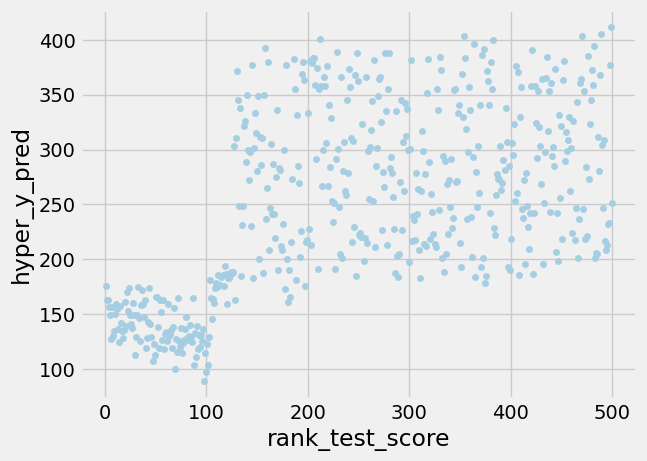

In [81]:
hyper_df.plot.scatter (hyper_y_name , "hyper_y_pred")

In [82]:
hyper_model.feature_names_in_

array(['param_n_estimators', 'param_max_depth', 'param_min_samples_split',
       'param_min_samples_leaf'], dtype=object)

In [83]:
#negative is better : rank
for  p,c in zip ( hyper_model.feature_names_in_ , hyper_model.coef_):print (p,c)

#param_min_samples_leaf -4.9405210916852935  , increase  param_min_samples_leaf
#param_min_samples_split -2.3606866063768948 , increase  param_min_samples_split

param_n_estimators -0.2712407163093835
param_max_depth 4.1966809568721555
param_min_samples_split -2.3606866063768948
param_min_samples_leaf 2.8122749953883477


In [50]:
from sklearn.linear_model import LinearRegression

hyper_modelparam_features = ["param_" + p for p in  list (param_dist.keys())]
print (hyper_modelparam_features)
hyper_X                   = cv_df [hyper_modelparam_features]
hyper_y_name              = "mean_fit_time"
hyper_y                   = cv_df [hyper_y_name ]

hyper_model               = LinearRegression ()
hyper_model.fit (hyper_X,hyper_y)

print ("hyper_model.score (hyper_X,hyper_y)", hyper_model.score (hyper_X,hyper_y))

hyper_y_pred             = hyper_model.predict (hyper_X)
hyper_df                 = (hyper_X.join (hyper_y)).join (pd.DataFrame (hyper_y_pred,columns = ["hyper_y_pred"]))
hyper_df.sort_values ("mean_fit_time")

['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']
hyper_model.score (hyper_X,hyper_y) 0.4290639932842921


,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_fit_time,hyper_y_pred
18,100,9,9,9,0.214351,0.272874
51,100,10,3,7,0.214928,0.243084
42,101,19,3,1,0.216317,0.196951
33,105,4,10,10,0.219266,0.298674
27,104,16,2,3,0.220755,0.218790
...,...,...,...,...,...,...
97,185,5,4,10,0.660904,0.497005
30,195,9,5,1,0.683598,0.458050
0,160,9,9,4,0.716463,0.396362
1,186,9,4,10,0.946915,0.497513


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='mean_fit_time', ylabel='hyper_y_pred'>

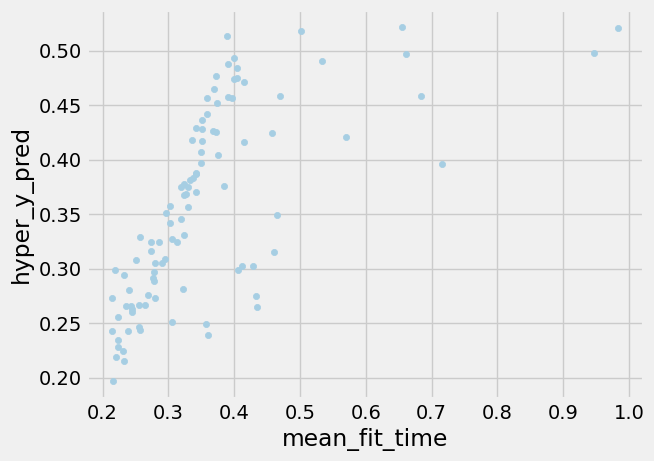

In [51]:
hyper_df.plot.scatter (hyper_y_name , "hyper_y_pred")

In [52]:
for  p,c in zip ( hyper_model.feature_names_in_ , hyper_model.coef_):print (p,c)
#more is worse , more time

param_n_estimators 0.002668429495263233
param_max_depth -0.0005399023837816064
param_min_samples_split 0.0024339368999427686
param_min_samples_leaf 0.007323634674429404


In [ ]:
from causalml.inference.meta import BaseTRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize the T-learner with RandomForest as the base regressor
t_learner = BaseTRegressor(learner=RandomForestRegressor())

# Fit the T-learner model
# X represents covariates, treatment is the treatment variable, and y is the outcome
t_learner.fit(X=data[['pluribus', 'rare']], treatment=data['chocolate'], y=data['winpercent'])

# Estimate the Average Treatment Effect (ATE)
ate = t_learner.estimate_ate(X=data[['pluribus', 'rare']], treatment=data['chocolate'], y=data['winpercent'])

# ate returns a tuple with the ATE estimate and confidence intervals, which can be printed or analyzed further
print(f"Estimated ATE: {ate[0]}")


Estimated ATE: [16.36288686]


In [ ]:
from causalml.inference.meta import BaseTRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define a function to estimate ATE and its confidence interval


# Example usage for 'chocolate'
X = data[['pluribus', 'rare']]
treatment = data['chocolate']
y = data['winpercent']

model = BaseTRegressor(learner=RandomForestRegressor())
model.fit(X=X, treatment=treatment, y=y)
ate, ate_lb, ate_ub = model.estimate_ate(X=X, treatment=treatment, y=y)

print(f"ATE: {ate}, Lower Bound: {ate_lb}, Upper Bound: {ate_ub}")


ATE: [16.21073238], Lower Bound: [11.21983483], Upper Bound: [21.20162993]


In [ ]:
# Predict the outcomes using the model for the treated and control groups
y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

# Combine predictions (this step may vary based on your specific needs and setup)
y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])

# Calculate R^2 and RMSE
r2 = r2_score(y_true_combined, y_pred_combined)
rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")


Prediction R^2: 0.13932761128299764, RMSE: 13.570330234198192


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming data, X, treatment, and y are already defined as per your dataset
X         = data[['pluribus', 'rare']]
treatment = data['chocolate']
y         = data['winpercent']

# Define the parameter distribution
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}


# Setup the Randomized Search with cross-validation for the entire dataset
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

# Perform the search on the entire dataset
random_search.fit(X, y)
best_params = random_search.best_params_


y_pred = random_search.predict (X)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")



# Apply the best hyperparameters to the RandomForestRegressor
optimized_rf = RandomForestRegressor(**best_params)

# Initialize the BaseTRegressor with the optimized RandomForestRegressor
t_learner = BaseTRegressor(learner=optimized_rf)

# Fit the T-learner to the full dataset
t_learner.fit(X=X, treatment=treatment, y=y)

# Estimate the ATE, its lower and upper bounds
ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


# Prediction performance evaluation would follow the same logic as before
# Predict the outcomes using the model for the treated and control groups
y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

# Combine predictions (this step may vary based on your specific needs and setup)
y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Prediction R^2: 0.11247428885576882, RMSE: 13.780404085613396
ATE: 19.613803535187124, Lower Bound: 14.692287109422132, Upper Bound: 24.535319960952116


In [ ]:
pd.DataFrame (random_search.cv_results_).to_csv ("hyperparams.csv")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming data, X, treatment, and y are already defined as per your dataset
X         = data[['pluribus', 'rare']]
treatment = data['chocolate']
y         = data['pricepercent']

# Define the parameter distribution
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}

# Setup the Randomized Search with cross-validation for the entire dataset
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

# Perform the search on the entire dataset
random_search.fit(X, y)
best_params = random_search.best_params_


y_pred = random_search.predict (X)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")



# Apply the best hyperparameters to the RandomForestRegressor
optimized_rf = RandomForestRegressor(**best_params)

# Initialize the BaseTRegressor with the optimized RandomForestRegressor
t_learner = BaseTRegressor(learner=optimized_rf)

# Fit the T-learner to the full dataset
t_learner.fit(X=X, treatment=treatment, y=y)

# Estimate the ATE, its lower and upper bounds
ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


# Prediction performance evaluation would follow the same logic as before
# Predict the outcomes using the model for the treated and control groups
y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

# Combine predictions (this step may vary based on your specific needs and setup)
y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming data, X, treatment, and y are already defined as per your dataset
X         = data[['pluribus', 'rare']]
treatment = data['chocolate']
y         = data['sugarpercent']

# Define the parameter distribution
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}

# Setup the Randomized Search with cross-validation for the entire dataset
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

# Perform the search on the entire dataset
random_search.fit(X, y)
best_params = random_search.best_params_



y_pred = random_search.predict (X)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")



# Apply the best hyperparameters to the RandomForestRegressor
optimized_rf = RandomForestRegressor(**best_params)

# Initialize the BaseTRegressor with the optimized RandomForestRegressor
t_learner = BaseTRegressor(learner=optimized_rf)

# Fit the T-learner to the full dataset
t_learner.fit(X=X, treatment=treatment, y=y)

# Estimate the ATE, its lower and upper bounds
ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


# Prediction performance evaluation would follow the same logic as before
# Predict the outcomes using the model for the treated and control groups
y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

# Combine predictions (this step may vary based on your specific needs and setup)
y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])



Fitting 10 folds for each of 100 candidates, totalling 1000 fits
ATE: 0.9675154236256951, Lower Bound: -9.896122199429856, Upper Bound: 11.831153046681246
Prediction R^2: 0.13082566029752463, RMSE: 26.207708419241023


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error


for y_col in ["winpercent", "pricepercent" , "sugarpercent"]:
    # Assuming data, X, treatment, and y are already defined as per your dataset
    print ("=="* 50)
    print ("y_col" , y_col)
    X         = data[['chocolate', 'rare']]
    treatment = data['pluribus']
    y         = data[y_col]

    # Define the parameter distribution
    param_dist = {
        "n_estimators": randint(100, 200),
        "max_depth": randint(3, 20),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 11)
    }

    # Setup the Randomized Search with cross-validation for the entire dataset
    random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

    # Perform the search on the entire dataset
    random_search.fit(X, y)
    best_params = random_search.best_params_


    y_pred = random_search.predict (X)

    # Calculate R^2 and RMSE
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"Prediction R^2: {r2}, RMSE: {rmse}")


    # Apply the best hyperparameters to the RandomForestRegressor
    optimized_rf = RandomForestRegressor(**best_params)

    # Initialize the BaseTRegressor with the optimized RandomForestRegressor
    t_learner = BaseTRegressor(learner=optimized_rf)

    # Fit the T-learner to the full dataset
    t_learner.fit(X=X, treatment=treatment, y=y)

    # Estimate the ATE, its lower and upper bounds
    ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

    print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


    # Prediction performance evaluation would follow the same logic as before
    # Predict the outcomes using the model for the treated and control groups
    y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
    y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

    # Combine predictions (this step may vary based on your specific needs and setup)
    y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
    y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])


    # Calculate R^2 and RMSE
    #r2 = r2_score(y_true_combined, y_pred_combined)
    #rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))

    #print(f"Prediction R^2: {r2}, RMSE: {rmse}")


y_col winpercent
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
ATE: -0.20628540670977064, Lower Bound: -4.76275411080641, Upper Bound: 4.350183297386868
Prediction R^2: 0.5015396673407027, RMSE: 10.327299748949185
y_col pricepercent
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
ATE: -0.010948428177623397, Lower Bound: -10.029095588421482, Upper Bound: 10.007198732066234
Prediction R^2: 0.3236115603643147, RMSE: 23.361392723457943
y_col sugarpercent
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error


for y_col in ["winpercent", "pricepercent" , "sugarpercent"]:
    # Assuming data, X, treatment, and y are already defined as per your dataset
    print ("=="* 50)
    print ("y_col" , y_col)
    X         = data[['chocolate' , 'pluribus']]
    treatment = data['rare']
    y         = data[y_col]

    # Define the parameter distribution
    param_dist = {
        "n_estimators": randint(100, 200),
        "max_depth": randint(3, 20),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 11)
    }

    # Setup the Randomized Search with cross-validation for the entire dataset
    random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

    # Perform the search on the entire dataset
    random_search.fit(X, y)
    best_params = random_search.best_params_

    # Apply the best hyperparameters to the RandomForestRegressor
    optimized_rf = RandomForestRegressor(**best_params)

    # Initialize the BaseTRegressor with the optimized RandomForestRegressor
    t_learner = BaseTRegressor(learner=optimized_rf)

    # Fit the T-learner to the full dataset
    t_learner.fit(X=X, treatment=treatment, y=y)

    # Estimate the ATE, its lower and upper bounds
    ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

    print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


    # Prediction performance evaluation would follow the same logic as before
    # Predict the outcomes using the model for the treated and control groups
    y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
    y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

    # Combine predictions (this step may vary based on your specific needs and setup)
    y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
    y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])

    # Calculate R^2 and RMSE
    r2 = r2_score(y_true_combined, y_pred_combined)
    rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))

    print(f"Prediction R^2: {r2}, RMSE: {rmse}")
